In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpltern

import seaborn as sns
sns.set_style("whitegrid")

# Linear Hypothesis in Arbitrary logits

This notebook explores the idea of making different categorical distributions comparable by fixing a desired attribute.
The first idea was how to compare different (and arbitrary) Priority dispatch rules (PDR), by making them stochastic instead of deterministic.
We explore the linear ranking hypothesis for chasing more desirable, automatically tunable stochastic PDR, with a low expected error with a fast implementation.
We found out the linear hypothesis works in practice, for most of the PDR's chosen, obtaining a good stochasticity and automatic temperature.

## Stochastic Priority Dispatch rules

Given a PDR defined by a specific rule $\rho : \mathcal{X} \to \mathbb{R}$, where $\mathcal{X}$ is the feature-space of tasks in our environment, we want to extend this dispatch rule to generate random sequences such that the probability of selecting $x_i$ at any time is
$$\mathbb{P}(x_i\text{ selected}) \propto \exp(\rho(x_i))$$

Therefore, we can then interpret each priority value as the likelihood of being chosen.
Furthermore, we can assume the odds of a given task to be chosen is independent on the pool of tasks, *i.e.*, for every task, the probability of choosing a task is always proportional to its probability of being chosen among any subset of task.

$$\mathbb{P}(x_i\text{ selected over } A) = \mathbb{P}(x_i\text{ selected over } B) \cdot \sum_{x \in B} \mathbb{P}(x\text{ selected over } B) \quad \forall x_i \in A$$

This is a simplistic model where we do not need to update our beliefs every time a task is chosen, opposed to a recurrent model, or a dynamic rule.
The equation above is called Luce's choice axiom, and appears in many models that approximate rational decision process due to its ease in ranking, providing a good proxy to more general models that require a full description of the generative process.
As it is simple to model and to do inference, it well suits the static dispatch rule perspective, generating sequences that are
- Simple to sample from
- Highly interpretable
- Easy to make assumption

The model we have chosen is the **Plackett-Luce** model, that ranks the items in a pool by selecting them, one by one, without replacement by the following rule

$$\mathbb{P}(x_i\text{ selected over } X) = \frac{\exp(\rho(x_i))}{\sum_{x \in X} \exp(\rho(x))}$$


One problem that may emerge from this, is that $\rho$ is possibly unbounded, and its value is just meaningful whe comparing tasks by value, the distance between them is not directly interpretable inside a same rule, or compared between rules.
For example, let $\rho_1, \rho_2$ be two distinct priority rules, we could sample from them directly, but the distribution $\rho_1$ will have different characteristics from $\rho_2$, which only depends on the tasks.
This means that for two different instances, $\rho_1$ might have arbitrary variance from the task's data, where $\rho_2$'s distribution is too sensible, generating almost random noise every sample.

To illustrate this behavior, we have produced a same PDR, but with different scales: The first has a expected gap between priority values in the order of 10, until the last, which is scaled by 0.01, producing priority values that are very close.
This can happen depending on the data provided from the tasks, which is not described and whose distribution is not assumed, therefore, a same environment where the weights happen to be scaled by 100, produces a much more deterministic stochastic policy when compared to the original environment.
That behavior is unintended, because who is using the PDR is responsible checking the distribution on their data and also have to understand how the PDR use the data to provide the priority values, and how these assumptions change the output distribution.
Moreover, the priority values are very different when we try to compare different PDR, their probabilities, entropy, variance, changes arbitrarely in a way that we cannot directly measure their impact on data due to an increasing uncertainty coming from the black-box PDR.

In [2]:
scales = np.array([10., 1., 0.1, 0.01])
temps = np.array([0.1, 0.5, 1.0, 2.0])

n_pdrs = len(scales)
n_temps = len(temps)
n_categories = 10
n_samples = 100_000

rng = np.random.default_rng(0)

pdrs = (rng.random(n_categories)[None, :] * scales[:, None])

chosen = np.argmax(
    rng.gumbel(0, 1, size=(n_samples, n_temps, n_pdrs, n_categories))
    * temps[None, :, None, None]
    + pdrs[None, None, :, :]
, axis=-1
)

one_hot = np.eye(n_categories)[chosen]
counts = one_hot.sum(axis=0) / n_samples

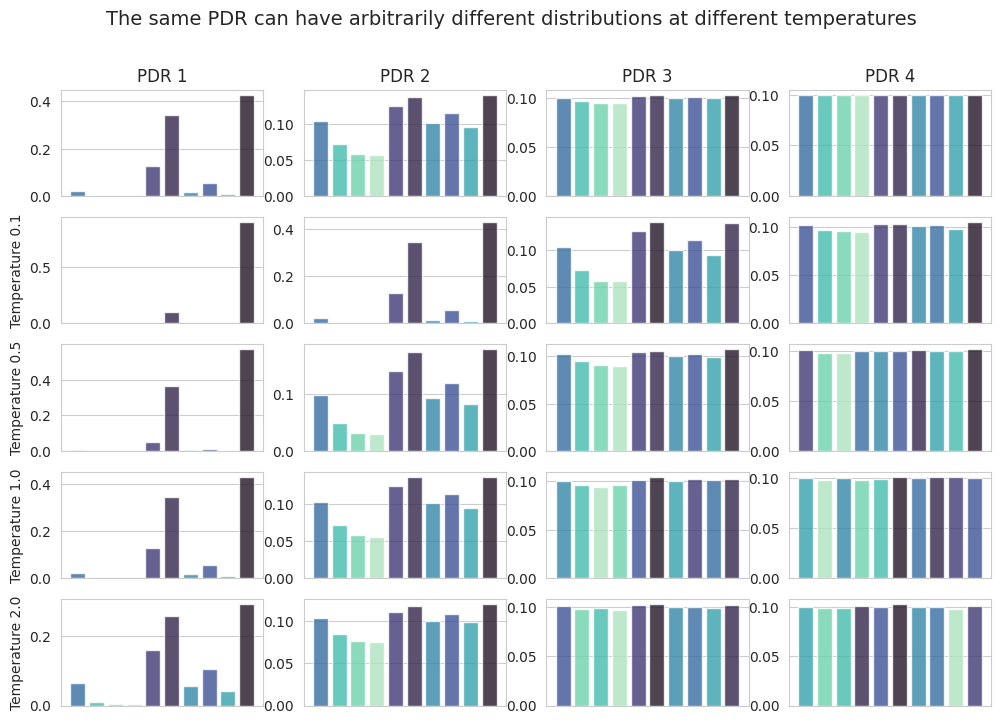

In [3]:
fig, axs = plt.subplots(len(temps) + 1, n_pdrs, figsize=(12, 8))

fig.suptitle("The same PDR can have arbitrarily different distributions at different temperatures", fontsize=14)

palette = sns.color_palette("mako", n_categories)

for i, temp in enumerate(temps, 1):
    axs[i, 0].set_ylabel(f'Temperature {temp}')

for j in range(n_pdrs):
    # Plot each categorical distribution
    probs = np.exp(pdrs[j] - np.max(pdrs[j]))
    probs /= np.sum(probs)
    
    ranks = np.argsort(-probs).argsort()

    axs[0, j].set_title(f'PDR {j + 1}')
    axs[0, j].bar(
        np.arange(n_categories),
        probs,
        width=0.8,
        color=[palette[r] for r in ranks],
        alpha=0.8,
        label='Original'
    )
    axs[0, j].set_xticks([])

    for i in range(len(temps)):
        ranks = np.argsort(-counts[i, j]).argsort()
        
        axs[i+1, j].bar(
            np.arange(n_categories),
            counts[i, j],
            width=0.8,
            color=[palette[r] for r in ranks],
            alpha=0.8,
            label='Sampled'
        )
        axs[i+1, j].set_xticks([])


The stochasticity of a PDR, as we can see above, could be controlled by a temperature value $\tau > 0$, which increases the entropy of the sampling distribution, so tasks priorities are re-scaled, and sampled with probability

$$\mathbb{P}(x_i\text{ selected over } X) = \frac{\exp(\rho(x_i) / \tau)}{\sum_{x \in X} \exp(\rho(x) / \tau)}$$

This helps adjusting the entropy of the output, getting more deterministic when $\tau \to 0$, and more uniform when $\tau \to \infty$.
However, as we can see above, the same value of $\tau$, depending on the original distribution, can vary significantly, or not vary at all.
In the PDR 4 example, where priority values are clustered together, any value of temperature is enough to obtain a perfect ranking of the tasks when compared to the baseline, which induces a high variance to the PDR that is not common to the other scaled versions.
This means that not only the user is responsible to understand the relationship between the data and the rule, but also it's their responsability to tune the temperature accordingly, which is not ideal.

Instead, a proposed solution would be min-max scaling the logits before sampling, so different scales can be ignored

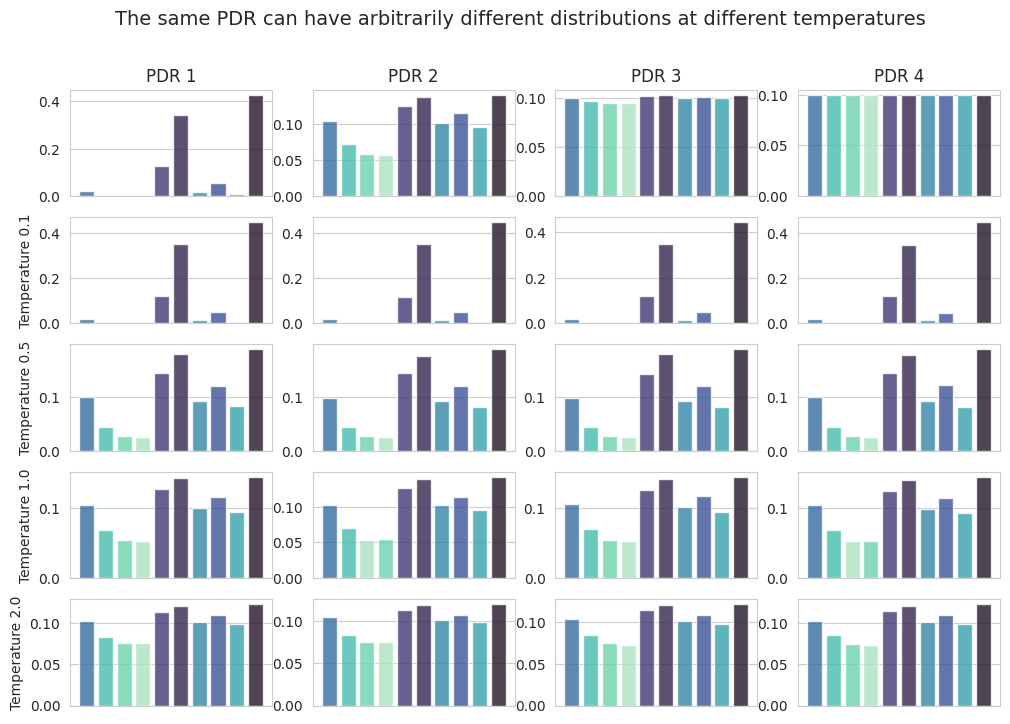

In [4]:
scaled_pdrs = pdrs - pdrs.min(axis=1, keepdims=True)
scaled_pdrs /= scaled_pdrs.max(axis=1, keepdims=True)

scaled_chosen = np.argmax(
    rng.gumbel(0, 1, size=(n_samples, n_temps, n_pdrs, n_categories))
    * temps[None, :, None, None]
    + scaled_pdrs[None, None, :, :]
, axis=-1
)

scaled_one_hot = np.eye(n_categories)[scaled_chosen]
scaled_counts = scaled_one_hot.sum(axis=0) / n_samples

fig, axs = plt.subplots(len(temps) + 1, n_pdrs, figsize=(12, 8))

fig.suptitle("The same PDR can have arbitrarily different distributions at different temperatures", fontsize=14)

palette = sns.color_palette("mako", n_categories)

for i, temp in enumerate(temps, 1):
    axs[i, 0].set_ylabel(f'Temperature {temp}')

for j in range(n_pdrs):
    # Plot each categorical distribution
    probs = np.exp(pdrs[j] - np.max(pdrs[j]))
    probs /= np.sum(probs)
    
    ranks = np.argsort(-probs).argsort()

    axs[0, j].set_title(f'PDR {j + 1}')
    axs[0, j].bar(
        np.arange(n_categories),
        probs,
        width=0.8,
        color=[palette[r] for r in ranks],
        alpha=0.8,
        label='Original'
    )
    axs[0, j].set_xticks([])

    for i in range(len(temps)):
        ranks = np.argsort(-scaled_counts[i, j]).argsort()
        
        axs[i+1, j].bar(
            np.arange(n_categories),
            scaled_counts[i, j],
            width=0.8,
            color=[palette[r] for r in ranks],
            alpha=0.8,
            label='Sampled'
        )
        axs[i+1, j].set_xticks([])


The proposal here is to parameterize the stochastic PDR to a concrete, interpretable parameter that implies a common property, agnostic to the priority rule, serving as an automatic tuner for the probability distribution risen from $\rho$, without knowing how the rule is computed.

## Linear hypothesis in the general PDR

We first explore some PDR properties that ensures that the stochastic variant is well-behaved and can be easily tuned.
- We model the problem as a Plackett-Luce model with scaled priorities, where a certain target is desired. This target is a probability target $p^*$ that have the following property:

Given a min-max scaled priority array $\mathbf{x}$, we want to sample from a Plackett-Luce model in the values of $\mathbf{x}$ with the ideal condition that, at any time, if $X$ is the set of remaining tasks to be ranked, then the probability of taking the task with maximum value in $X$ is (approximately) $p^*$,

$$\mathbb{P}((\arg\max_{i \in X} \mathbf{x_i}) \text{ selected in } X) \approx p^*$$

The major problem with this property is that, as the priority values can vary independently, we could have any combination of values and finding a single temperature value that satisfies the property above is unfeasible.
However, supposed that $\mathbf{x}$ is nice and satisfies the property for some $p$, then, for every $X$, subset of the 

$$\frac{\exp(\max_i\rho(x_i))}{\sum_{x \in X} \exp(\rho(x))} \approx p$$

Let $Z_1 = {\sum_{x \in X} \exp(\rho(x))}$, we know that the maximum is in $X$, therefore, call $X_1 = X \setminus \{i\}$, and $Z_1 =\exp(\max_i\rho(x_i)) + \sum_{x \in X_1} \exp(\rho(x))$. So, we can write, by defining $Z_k$ to be the sum of the exponential of the least $k$ terms and $\rho_k$, the $k$-th greatest priority value:

$$
\begin{align*}
\exp(\rho_1) &\approx p Z_1\\
\exp(\rho_1) &\approx p \left(\exp(\rho_1) + \sum_{x \in X_1} \exp(\rho(x))\right)\\
\exp(\rho_1) &\approx p \exp(\rho_1) + p \sum_{x \in X_1} \exp(\rho(x)) \\
\exp(\rho_1) &\approx p \exp(\rho_1) + p Z_2
\end{align*}
$$

However, as $Z_2$ contains every element besides the maximum, $pZ_2$ is approximately the exponential of the second greatest priority,

$$
\begin{align*}
\exp(\rho_1) &\approx p \exp(\rho_1) + p Z_2\\
\exp(\rho_1) &\approx p \exp(\rho_1) + \exp(\rho_2)\\
\exp(\rho_2) &\approx (1-p) \exp(\rho_1)\\
\therefore \rho_2 &\approx \rho_1 + \ln(1-p)
\end{align*}
$$

A PDR satisfies the property of homogeneous sampling if the priority values are linear, as this analysis is not particular for the first and second greatest elements, but for any $k$-th and $k+1$-th greatest, therefore, $\rho_k \approx \rho_{k-1} + \ln(1-p)$, which, by induction, means that

$$\rho_k \approx \rho_{1} + \ln(1-p) (k-1).$$

So, if $\rho$ decays linearly when evaluated to a set of tasks $X$ over the ranks, then the homogeneous property holds.
This result is important because we can encode the distribution of priority values by the linear parameter.
Supposes the values $\rho_1 \leq \rho_2 \leq \dots \leq \rho_k \leq \rho_{k+1}$ are linearly decaying with respect to the rank $k$, therefore, exists $\lambda$ and $Z$ such that

$$\rho_k = -\lambda k - Z$$

This choice of parameters induces a exponential decay on the logits, so

$$\mathbb{P}(\rho_k \text{ selected}) \propto \exp(-\lambda k)$$

Which have $p$, in the homogeneous property, equals to

$$p = \frac{1 - \exp(-\lambda)}{1 - \exp(-\lambda n)}$$
where $n = |X|$ and do not depend on the original logits, if $\lambda > 0$ exists.
Therefore, some PDR can have a target $p^*$ by changing the $\lambda$ to carry a temperature value $\tau$, such that

$$p^* = \frac{1 - \exp(-\lambda / \tau)}{1 - \exp(-\lambda n / \tau)}$$

This works because the linear parameter is scaled by the temperature parameter, therefore, if $\tau$ satisfies the equation above, then the stochastic PDR

$$\frac{\exp(\max_i\rho(x_i) / \tau)}{\sum_{x \in X} \exp(\rho(x) / \tau)} = p^*$$

Which has the desired property, independently from the input priorities.


Our hypothesis is that, by assuming the priority values are linearly distributed with respect to the rank, we can still sample from a well-behaved stochastic PDR by choosing a $p^*$ parameter rule-free.
We test this hypothesis in the 3-simplex to obtain visualizations and gather intuition when these strategies may work, finally we test this methodology in higher dimensions.

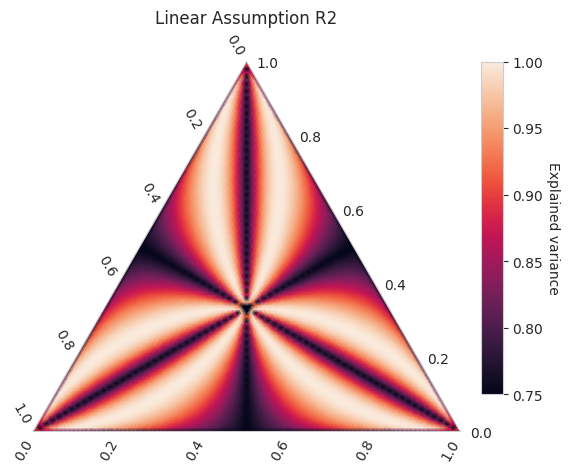

In [7]:
def generate_simplex_grid_numpy(K: int) -> np.ndarray:    
    # Generate all (k1, k2)
    k1 = np.arange(K + 1)
    k2 = np.arange(K + 1)
    k1g, k2g = np.meshgrid(k1, k2, indexing='ij')
    
    # k3 is determined
    k3g = K - k1g - k2g
    
    # Only keep valid points where k3 >= 0
    mask = k3g >= 0
    k1_flat = k1g[mask]
    k2_flat = k2g[mask]
    k3_flat = k3g[mask]
    
    # Stack and normalize
    grid = np.stack([k1_flat, k2_flat, k3_flat], axis=1) / K

    return grid

n = 3
K = 100

probs = generate_simplex_grid_numpy(K)
log_probs = np.log(probs + 1e-10)

sorted_probs    = -np.sort(-probs, axis=1)
sorted_logprobs = -np.sort(-log_probs, axis=1)

lmbds = 12/(n*(n+1)*(n-1)) * np.sum(sorted_logprobs * ((n+1)/2 - np.arange(1, n+1)), axis=1)
logZs = - np.mean(sorted_logprobs, axis=1) - lmbds * (n+1)/2
ss_res = ((sorted_logprobs + lmbds[:, None] * np.arange(1, n+1) + logZs[:, None])**2).sum(axis=1)
ss_total = ((sorted_logprobs - sorted_logprobs.mean(axis=1, keepdims=True))**2).sum(axis=1)

R2 = 1 - ss_res / ss_total

fig = plt.figure(figsize=(10.8, 4.8))

p_max = (1 - np.exp(-lmbds))/(1 - np.exp(-lmbds * n))

ax = fig.add_subplot(1, 1, 1, projection='ternary')
cs = ax.tripcolor(*probs.T, R2, shading='gouraud', rasterized=True, vmax=1.) # type: ignore
ax.set_title("Linear Assumption R2")

cax = ax.inset_axes((1.05, 0.1, 0.05, 0.9), transform=ax.transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('Explained variance', rotation=270, va='baseline')

plt.show()

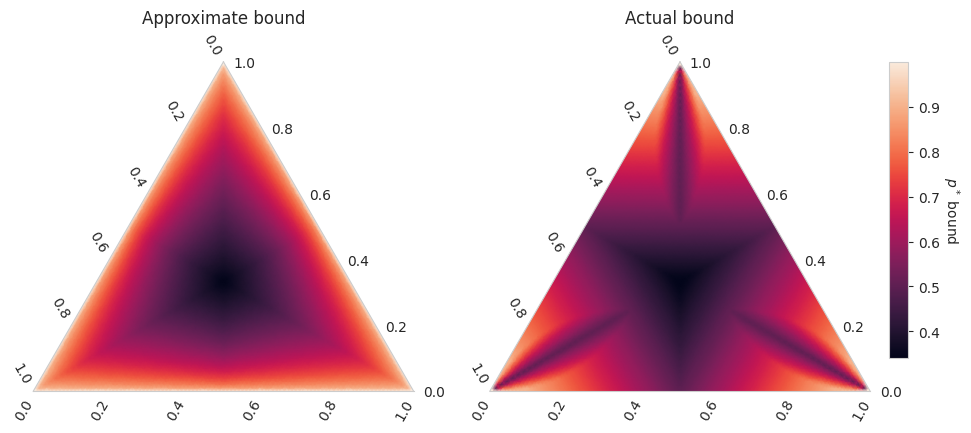

In [8]:
fig = plt.figure(figsize=(10.8, 4.8))
n_rows, n_cols = 1, 2

p_max = (1 - np.exp(-lmbds))/(1 - np.exp(-lmbds * n))

p_star = np.min(
    (1e-10 + sorted_probs) /
    (1e-10 + np.sum(sorted_probs, axis=1, keepdims=True) - np.cumsum(sorted_probs, axis=1) + sorted_probs)
, axis=1)

ax = fig.add_subplot(n_rows, n_cols, 1, projection='ternary')
cs = ax.tripcolor(*probs.T, p_max, shading='gouraud', vmin=1/n, vmax=1, rasterized=True) # type: ignore
ax.set_title("Approximate bound")

ax = fig.add_subplot(n_rows, n_cols, 2, projection='ternary')
cs = ax.tripcolor(*probs.T,  p_star, shading='gouraud', rasterized=True) # type: ignore
ax.set_title("Actual bound")

cax = ax.inset_axes((1.05, 0.1, 0.05, 0.9), transform=ax.transAxes)
colorbar = fig.colorbar(cs, cax=cax)
colorbar.set_label('$p^*$ bound', rotation=270, va='baseline')

plt.show()

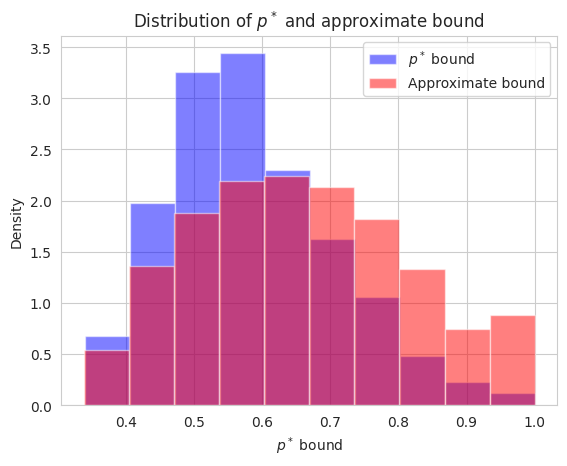

In [9]:
plt.hist(p_star, bins=10, density=True, alpha=0.5, color='blue', label='$p^*$ bound')
plt.hist(p_max, bins=10, density=True, alpha=0.5, color='red', label='Approximate bound')

plt.xlabel('$p^*$ bound')
plt.ylabel('Density')

plt.title('Distribution of $p^*$ and approximate bound')
plt.legend()

plt.show()

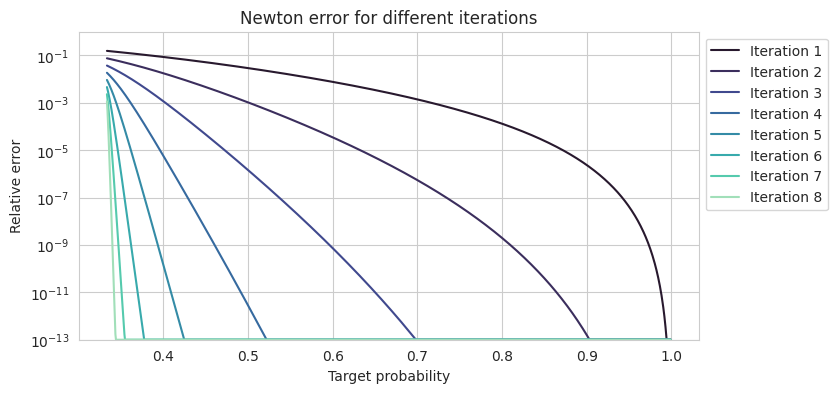

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))

p_target = np.linspace(1/n, 0.999, 1000)
x = 1 - p_target

n_newton = 0
while np.abs((1 - x) / (1 - x**n) - p_target).max() > 1e-13:
    n_newton += 1
    x = (p_target * x**n *(n-1) - (1 - p_target)) / (n * p_target * x**(n-1) - 1)

x_newton = (p_target * (1 - p_target)**n *(n-1) - (1 - p_target)) / (n * p_target * (1 - p_target)**(n-1) - 1)
n_iter = n_newton // 3

palette = sns.color_palette("mako", n_iter)
for i in range(n_iter):
    relative_error = np.maximum(np.abs(x - x_newton) / x, 1e-13)

    ax.plot(
        p_target,
        relative_error,
        label=f'Iteration {i + 1}',
        color=palette[i],
    )
    x_newton = (p_target * x_newton**n *(n-1) - (1 - p_target)) / (n * p_target * x_newton**(n-1) - 1)

ax.set_xlabel('Target probability')
ax.set_ylabel('Relative error')

ax.set_title('Newton error for different iterations')

ax.set_yscale('log')
ax.set_ylim(1e-13, 1)

# Legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

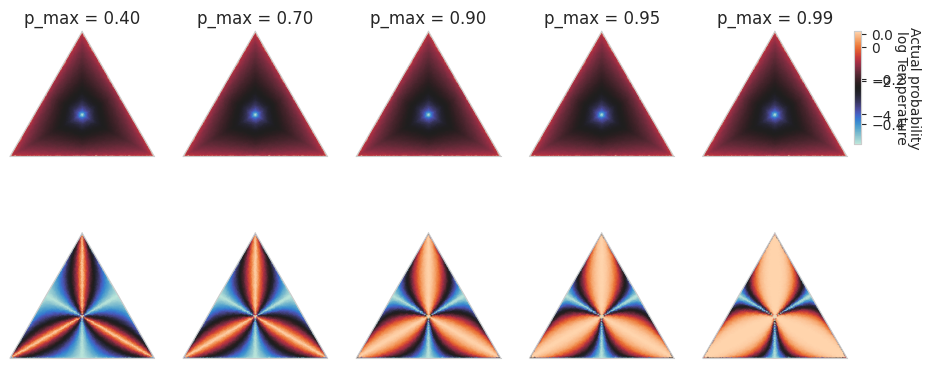

In [41]:
fig = plt.figure(figsize=(10.8, 4.8))

lmbda_target = -np.log(x)
desired_max_ps = [0.4, 0.7, 0.9, 0.95, 0.99]


for i, p in enumerate(desired_max_ps, 1):
    temp = lmbds / lmbda_target[np.searchsorted(p_target, p)]
    new_p = np.exp(log_probs.max(axis=1) / temp) / np.exp(log_probs / temp[:, None]).sum(axis=1)

    ax = fig.add_subplot(2, len(desired_max_ps), i, projection='ternary')
    cs = ax.tripcolor(*probs.T, np.log(temp), shading='gouraud',rasterized=True, cmap='icefire') # type: ignore
    ax.set_title(f"p_max = {p:.2f}")

    ax.taxis.set_ticks([]) # type: ignore
    ax.laxis.set_ticks([]) # type: ignore
    ax.raxis.set_ticks([]) # type: ignore

    ax1 = fig.add_subplot(2, len(desired_max_ps),  i + len(desired_max_ps), projection='ternary')
    cs1 = ax1.tripcolor(*probs.T, new_p -  p, shading='gouraud',rasterized=True, cmap='icefire') # type: ignore

    ax1.taxis.set_ticks([]) # type: ignore
    ax1.laxis.set_ticks([]) # type: ignore
    ax1.raxis.set_ticks([]) # type: ignore


cax = ax.inset_axes((1.05, 0.1, 0.05, 0.9), transform=ax.transAxes)
colorbar = fig.colorbar(cs, cax=cax) # type: ignore
colorbar.set_label('log Temperature', rotation=270, va='baseline')

cax1 = ax1.inset_axes((1.05, 0.1, 0.05, 0.9), transform=ax.transAxes) # type: ignore
colorbar = fig.colorbar(cs1, cax=cax1) # type: ignore
colorbar.set_label('Actual probability', rotation=270, va='baseline')

plt.show()

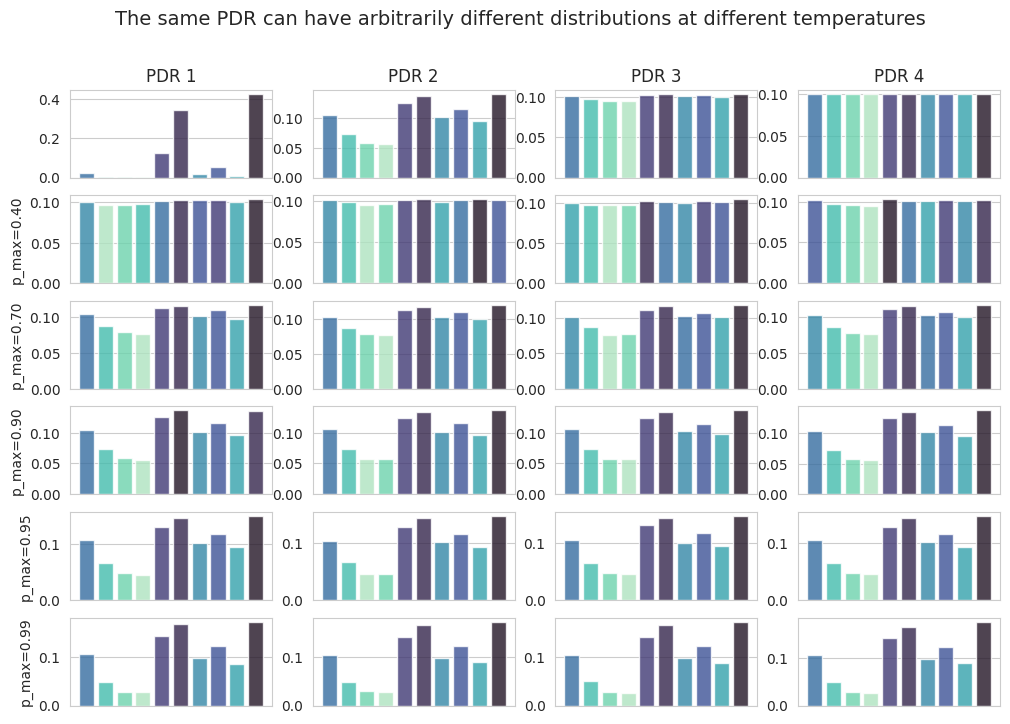

In [43]:
scales = np.array([10., 1., 0.1, 0.01])
target_probs = np.array([0.4, 0.7, 0.9, 0.95, 0.99])

n_pdrs = len(scales)
n_probs = len(target_probs)
n_categories = 10
n_samples = 100_000

n_iter = 5

# ======= Linear Assumption =======

sorted_priorities = -np.sort(-pdrs, axis=1)

lambdas = 12 * np.sum(sorted_priorities * ((n+1)/2 - np.arange(1, n_categories+1)), axis=1) / (n*(n+1)*(n-1))

x = 1 - target_probs

for _ in range(n_iter):
    x = (target_probs * x**n *(n-1) - (1 - target_probs)) / (n * target_probs * x**(n-1) - 1)

temps = lambdas / -np.log(x)[:, None]

# =================================

sampled = np.zeros((n_samples, n_probs, n_pdrs, n_categories))

chosen = np.argmax(
    rng.gumbel(0, 1, size=(n_samples, n_probs, n_pdrs, n_categories))
    * temps[None, :, :, None]
    + pdrs[None, None, :, :]
, axis=-1
)

one_hot = np.eye(n_categories)[chosen]
counts = one_hot.sum(axis=0) / n_samples

fig, axs = plt.subplots(len(temps) + 1, n_pdrs, figsize=(12, 8))

fig.suptitle("The same PDR can have arbitrarily different distributions at different temperatures", fontsize=14)

palette = sns.color_palette("mako", n_categories)

for i, prob in enumerate(target_probs, 1):
    axs[i, 0].set_ylabel(f'p_max={prob:.2f}')

for j in range(n_pdrs):
    # Plot each categorical distribution
    probs = np.exp(pdrs[j] - np.max(pdrs[j]))
    probs /= np.sum(probs)
    
    ranks = np.argsort(-probs).argsort()

    axs[0, j].set_title(f'PDR {j + 1}')
    axs[0, j].bar(
        np.arange(n_categories),
        probs,
        width=0.8,
        color=[palette[r] for r in ranks],
        alpha=0.8,
        label='Original'
    )
    axs[0, j].set_xticks([])

    for i in range(n_probs):
        ranks = np.argsort(-counts[i, j]).argsort()
        
        axs[i+1, j].bar(
            np.arange(n_categories),
            counts[i, j],
            width=0.8,
            color=[palette[r] for r in ranks],
            alpha=0.8,
            label='Sampled'
        )
        axs[i+1, j].set_xticks([])


As we can see, the parameter for the maximum probability is robust to the input distribution, obtaining similar distributions for the first task choice, regardless of the scale.

## A stronger hypothesis

The linear hypothesis encodes the distributions into a univariate parameter $\lambda$, and operates in that space that is easier to move from one distribution from another.
However, we could get a stronger property we call $p$-homogeneous.

> **Definition** ( $p$-homogeneous) A categorical distribution with $n$ categories is called $p$-homogeneous if, for every subset $X \subseteq [n]$ there exists $p^* > 0$ such that
> $$\frac{\max_{i \in X} p_i}{\sum_{i \in X} p_i} \geq p^*$$

Without loss of generality, consider the probabilities in decresing order $p_1 \geq p_2 \geq \cdots \geq p_n$, the $p$-homogeneous property need not to be evaluated at every subset $X$, but only in the tail probabilities, as they offer a lower bound for every subset $X \subseteq [n]$.
Let $k \in [n]$ arbitrary and any $X \subseteq [n]$ such that $\forall i \in X (p_i \leq p_k)$, as $p_j \geq 0$ for every probability in the distribution, then $\sum_{i \in X} p_i \leq \sum_{i= k}^{n} p_i$